In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import nbodykit.lab as nb
from matplotlib.gridspec import GridSpec
from scipy.stats import binned_statistic
import numpy as np


In [2]:
plt.rc('font', size=15)

In [4]:
def rebin(k, ke, pk, nm):
    """ Re-Bin the measured power spectrum after a pivot point
    """
    kpv = 0.02   # pivot k, i.e., we rebin spectrum for k > kpv
    dk = 0.01    # new binning width
    
    kmax = ke.max()
    bins = ke[ke < kpv].tolist() +  np.arange(kpv, kmax, dk).tolist()
    bins = np.array(bins)

    nm_bin = binned_statistic(k, nm, statistic='sum', bins=bins)[0]
    k_bin_ = binned_statistic(k, k*nm, statistic='sum', bins=bins)[0]
    pk_bin_ = binned_statistic(k, pk*nm, statistic='sum', bins=bins)[0]

    k_bin = k_bin_ / nm_bin
    pk_bin = pk_bin_ / nm_bin
    
    return k_bin, pk_bin

def read_pk(filename):
    pk_raw = nb.ConvolvedFFTPower.load(filename)
    
    k = pk_raw.poles['k']
    ke = pk_raw.poles.edges['k']
    p0 = pk_raw.poles['power_0'].real
    ps = pk_raw.attrs['shotnoise']
    nm = pk_raw.poles['modes']

    return rebin(k, ke, p0-ps, nm)

def add_pk(x, y, ax1, ax2=None, xk=True, **kw):
    
    if xk:
        ax1.plot(x, x*y, **kw)
        if ax2 is not None:
            ax2.plot(x, x*y, **kw, zorder=-1)
    else:
        ax1.plot(x, y, **kw)
        if ax2 is not None:
            ax2.plot(x, y, **kw, zorder=-1)

        
            
def add_fill(x, y1, y2, ax1, ax2=None, xk=True, **kw):
    if xk:        
        ax1.fill_between(x, x*y1, x*y2, **kw)
        if ax2 is not None:
            ax2.fill_between(x, x*y1, x*y2, **kw, zorder=-1)   
    else:
        ax1.fill_between(x, y1, y2, **kw)
        if ax2 is not None:
            ax2.fill_between(x, y1, y2, **kw, zorder=-1)   

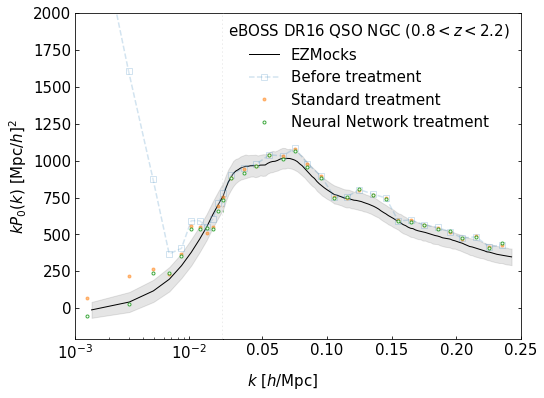

In [31]:
cap = 'NGC'
sample = 'main'
method = 'known'

zlim = {'main':'$0.8<z<2.2$',
        'highz':'$2.2<z<3.5$'}

#--- Read inputs

# # mocks
pks_all = np.load('./pk_ezmocks_ngcsgc_v1.0.npz', allow_pickle=True)
pks_mocks = pks_all[f'{cap}_null_standard_512']
covpks_all = np.load('./covpk_ezmocks_ngcsgc_v1.0.npz', allow_pickle=True)
covpks = covpks_all[f'{cap}_null_standard_512'].item()    
pk_err = np.sqrt(np.diagonal(covpks['covp0']))

# data
pks = {}
path = '/home/mehdi/data/eboss/data/v7_2/3.0/measurements/spectra'
pks['noweight'] = read_pk(f'{path}/spectra_{cap}_noweight_mainhighz_512_v7_2_{sample}.json')
pks['systot'] = read_pk(f'{path}/spectra_{cap}_knownsystot_mainhighz_512_v7_2_{sample}.json')
pks['nn'] = read_pk(f'{path}/spectra_{cap}_{method}_mainhighz_512_v7_2_{sample}.json')    



#--- Make the figure
fig = plt.figure(figsize=(8, 6))#figsize=(16, 10))
plt.subplots_adjust(wspace=0.0)
gs  = GridSpec(1, 2, width_ratios=[1, 2], figure=fig)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])


# cosmetics
ax1.tick_params(direction='in', axis='both', which='both', left=True, right=False)#, width=1, length=5)
ax2.tick_params(direction='in', axis='both', which='both', left=False, right=True)#, width=1, length=5)
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)


xmin, xbreak, xmax = (0.001, 0.02, 0.25)
ylim = (-210, 2000) # (-50000,100000) for Pk
ax1.set(xlim=(xmin, xbreak), xticks=[0.001, 0.01], 
        xticklabels=['0.001', '0.01'],
        ylim=ylim, xscale='log', ylabel=r'$kP_{0}(k)~[{\rm Mpc}/h]^{2}$')
ax1.axvline(xbreak, ls=':', color='grey', alpha=0.2)

ax2.set(xlim=(xbreak, xmax), xlabel=r'$k~[h/{\rm Mpc}]$', 
        ylim=ylim, yticklabels=[])
ax2.xaxis.set_label_coords(0.2, -0.1)    # https://stackoverflow.com/a/25018490/9746916


# ax3 = fig.add_axes([0.42, 0.18, 0.3, 0.3]) # for the inset
# ax3.set(xscale='log', xlim=(1.0e-3, 0.05), ylabel=r'$P_{0}(k)~[{\rm Mpc}/h]^{3}$')
# ax3.tick_params(direction='in', axis='both', which='both', right=True, top=True)

# add data and mocks
# mean and shade from the mocks
add_pk(pks_mocks[:, 0], pks_mocks[:, 2], ax1, ax2, ls='-', lw=1, color='k', label='EZMocks')
add_fill(pks_mocks[:, 0], pks_mocks[:, 2]-pk_err, pks_mocks[:, 2]+pk_err,  ax1, ax2, color='k', alpha=0.1)
add_pk(*pks['noweight'], ax1, ax2, marker='s', alpha=0.2, label='Before treatment', ls='--', mfc='w')
add_pk(*pks['systot'], ax1, ax2, marker='.', alpha=0.5, label='Standard treatment', ls='None',)
add_pk(*pks['nn'], ax1, ax2, marker='.', mfc='w', alpha=0.9, label='Neural Network treatment', ls='None')


# add_pk(pks_mocks[:, 0], pks_mocks[:, 2], ax3, xk=False, ls='-', lw=1, color='k', label='EZMocks')
# add_fill(pks_mocks[:, 0], pks_mocks[:, 2]-pk_err, pks_mocks[:, 2]+pk_err,  ax3, xk=False, color='k', alpha=0.1)
# add_pk(*pks['systot'], ax3, xk=False, marker='.', alpha=0.5, label='Standard treatment', ls='None', )
# add_pk(*pks['nn'], ax3, xk=False, marker='.', mfc='w', alpha=0.9, label='Neural Network treatment', ls='None')


ax2.legend(loc='lower left', frameon=False, 
           ncol=1, bbox_to_anchor=(-0.03, 0.6),
           title=fr"eBOSS DR16 QSO {cap} ({zlim[sample]})")

# fig.savefig('kpl.png', dpi=300, bbox_inches='tight')